In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Hand cleansed
Hand cleaned to removed duplicates

In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [3]:
cleansed.count().count()

123

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

Idea:

* Sort portfolios on an annual baisis
* cacluated $\sigma$, $\mu$, skew, max drawdown

* Need to creat panel data and start running regression on that.  

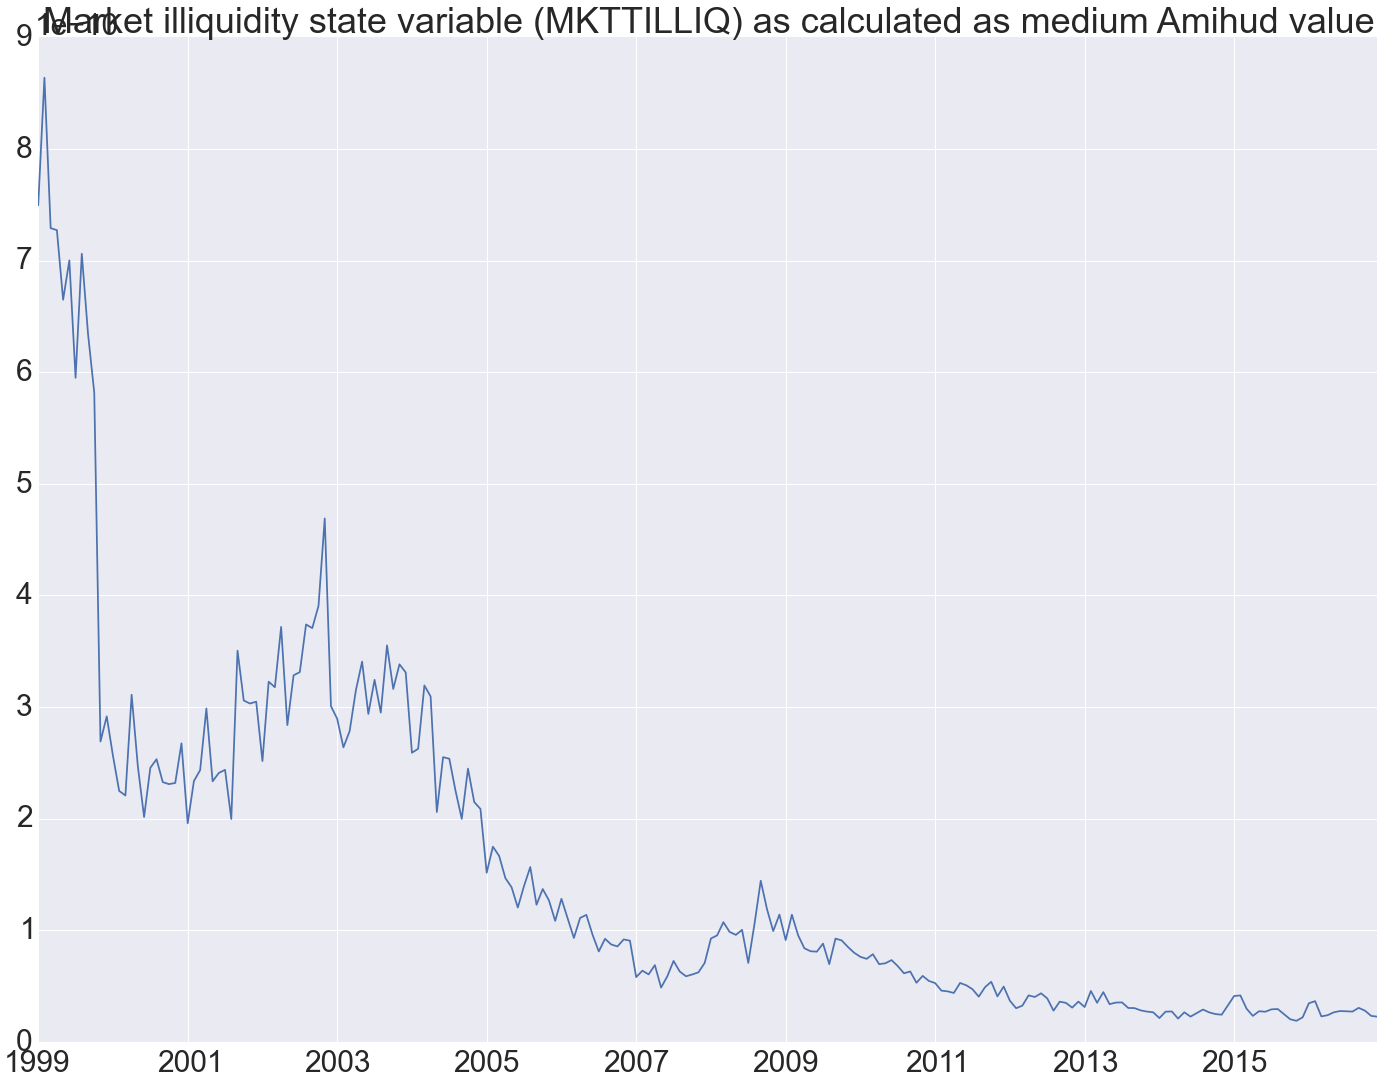

In [5]:
amihud.median(axis=1).dropna().plot(title='Market illiquidity state variable (MKTTILLIQ) as calculated as medium Amihud value')

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


In [6]:
un_dec=quantile_portfolios_annual(amihud,cleansed)

tsmom_model.py:210: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
tsmom_model.py:211: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


Tring scalled performance by volatility to equal but it is a mess.  I think this highlights something is further wrong in the data. 

In [7]:
scalled_rtns=cleansed.resample(rule='m',how='last').pct_change()/pd.ewmstd(cleansed.resample(rule='m',how='last').pct_change(),125,min_periods=60)*.15
scalled_prices=scalled_rtns.cumsum()
sc_dec=quantile_portfolios_annual(amihud,scalled_prices)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=60,adjust=True,com=125).std(bias=False)
  if __name__ == '__main__':


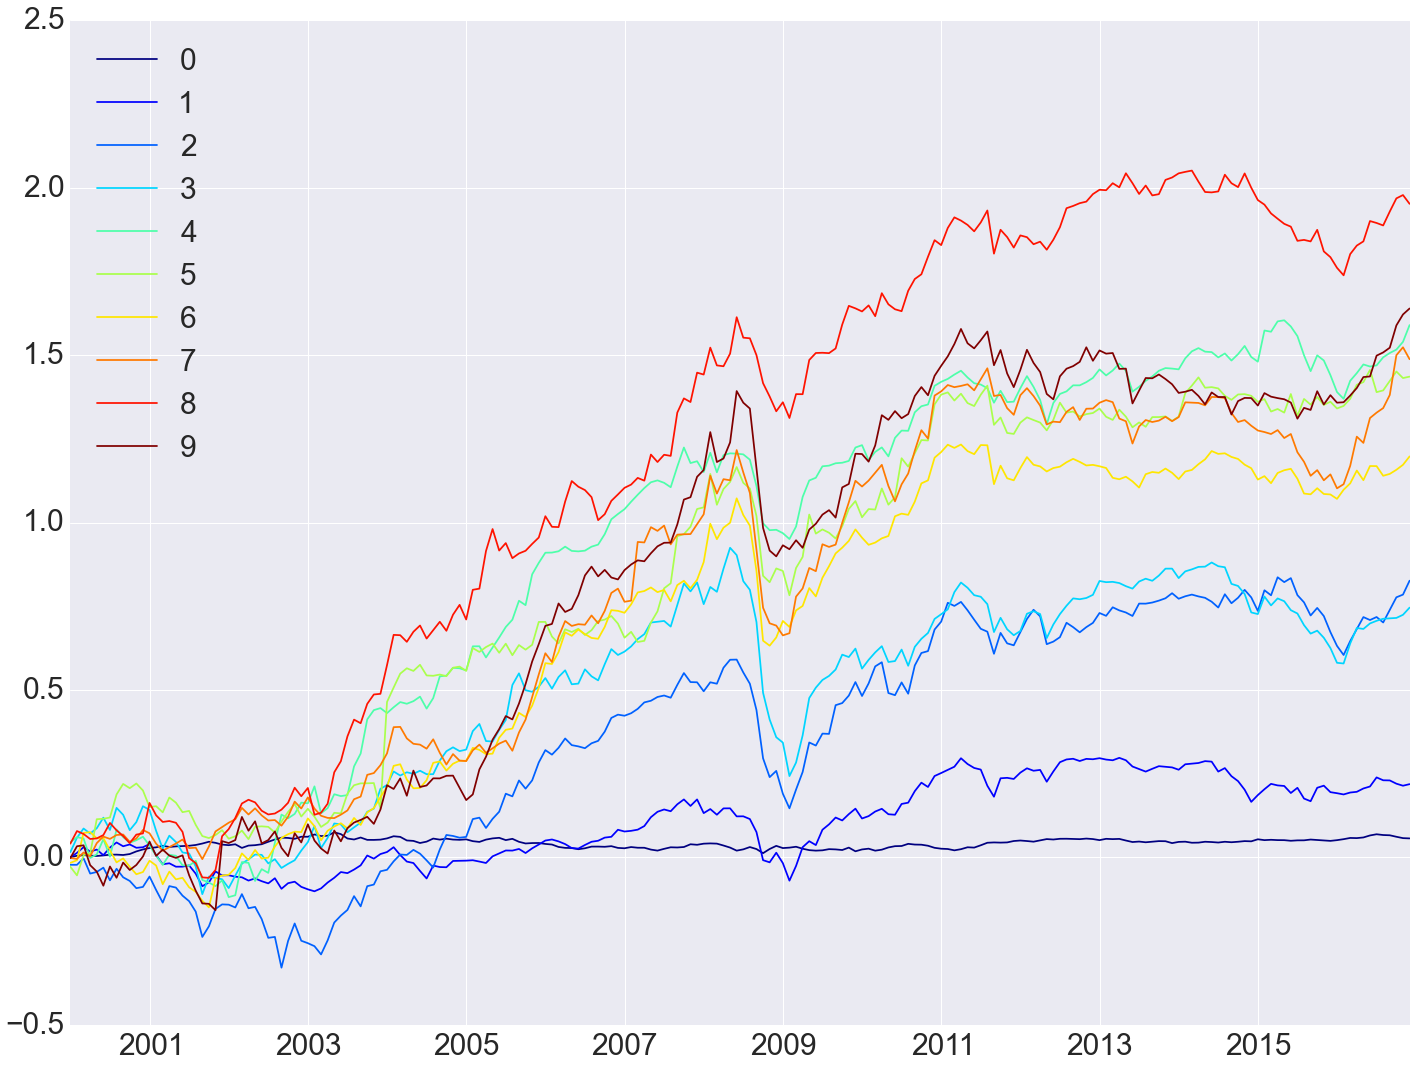

In [8]:
un_dec.dropna().cumsum().plot(colormap='jet')

In [9]:
un_dec.skew()

0   -0.264468
1   -0.447008
2   -0.475443
3   -1.032544
4   -0.002250
5    1.484012
6   -1.304429
7   -0.084724
8    0.198703
9   -0.182150
dtype: float64

# Table 1 for Paper 
Now run regression of these time series on the overall market liquidity

Then correlation matrix with state variables
* Overall market vol?
* Market illiquidity (median Amihud through time series)
* Transition matrix between groups.
* Perhaps we can add DOWN (dummy variable for when/if the market is down for two years a la Daniel and Moskowitz (2014)
* Market sentiment from one of the other papers
* NBER recessions
* TED spreads
* 


Need to find out:
* How do I run an autocorrelation analysis in python? Just AR(1)

Explination
* Highlight how portfolios were formed.  Equally weighted and formed annually or should we do monthly?
* Mention that this is excess returns (does not include fully funded positions i.e. with cash returns)

In [10]:
res=pd.DataFrame()
res['Monthly Return']=un_dec.mean()*100
res['Standard Deviation']=un_dec.std()*math.sqrt(12)*100
res['Sharpe']=calc_Sharpe(un_dec)
res['Skewness']=un_dec.skew()
res['Excess Kurtosis']=un_dec.kurtosis()
res['Amihud']='XXX'
res['CAPM Alpha (in %)']='XXX'
res['CAPM Beta (in %)']='XXX'
res['AR(1)']='XXX'
res.T.round(2)

,0,1,2,3,4,5,6,7,8,9
Monthly Return,0.0278178,0.107247,0.405144,0.365692,0.779356,0.703911,0.587066,0.729447,0.956949,0.803656
Standard Deviation,1.50344,6.59892,12.3877,13.337,12.123,15.5964,12.0538,14.5587,14.0603,15.8932
Sharpe,0.222034,0.195026,0.392463,0.329034,0.771449,0.541596,0.584446,0.601246,0.816724,0.606792
Skewness,-0.264468,-0.447008,-0.475443,-1.03254,-0.00225049,1.48401,-1.30443,-0.0847239,0.198703,-0.18215
Excess Kurtosis,0.434086,2.01462,1.03573,4.45862,0.837399,12.3643,8.06539,3.68027,0.497336,3.45634
Amihud,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX
CAPM Alpha (in %),XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX
CAPM Beta (in %),XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX
AR(1),XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX,XXX


# Further undersanding liquidity factor?

The further paper is trying to understand why do less liquid markets create this factor.  

Here are some ideas:
* Do some of the other state variables explain when illiquidity is profitable?  That's a bit weak, isn't it?  But if it is not you can run it on the IML, portfolio 1 and portfolio 10.  Something to ask new advisor.
* 

The other state variables:
* Amihud (MKTILLIQ)
* LIBOR
* Fed Funds
* TED
* Financial Stress
* NBER Recessions








Example regression which you will need to do for CAPM for each decile (but you will need to add intercept)

#  Potential state and control variables 

I think there are lots of possibilities:
* Amihud (MKTILLIQ)
* LIBOR
* Fed Funds
* TED
* Financial Stress
* NBER Recessions

For table 1 we should run correlation matrix on monthly data to see if these are explaining the same thing.  

In [ ]:
df=pd.DataFrame()
df['Amihud']=amihud.median(axis=1).dropna()
df['LIBOR']=quandl.get('FRED/USDONTD156N').VALUE.resample(rule='m',how='last')
df['FedFunds']=quandl.get('FRED/FEDFUNDS').Value.resample(rule='m',how='last')
df['TED']=quandl.get('FRED/TEDRATE').Value.resample(rule='m',how='last')
df['FinancialStress']=quandl.get('FRED/STLFSI').Value.resample(rule='m',how='last')
df['NBER_Recessions']=quandl.get('FRED/USREC').Value.resample(rule='m',how='last')
df.plot(secondary_y='NBER_Recessions')

In [ ]:
monthly_dec=quantile_portfolios_monthly(amihud,cleansed)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


In [ ]:
res=pd.DataFrame()
res['Monthly Return']=monthly_dec.mean()*100
res['Standard Deviation']=monthly_dec.std()*math.sqrt(12)*100
res['Sharpe']=calc_Sharpe(monthly_dec)
res['Skewness']=monthly_dec.skew()
res['Excess Kurtosis']=monthly_dec.kurtosis()
res['Amihud']='XXX'
res['CAPM Alpha (in %)']='XXX'
res['CAPM Beta (in %)']='XXX'
res['AR(1)']='XXX'
res.T.round(2)

In [ ]:
monthly_dec.cumsum().plot(colormap='jet')